# Face Recognition Project

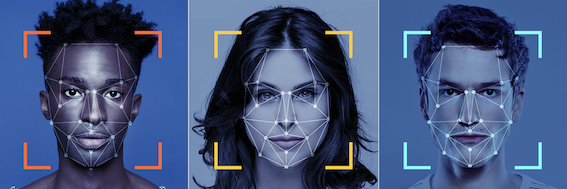

In [1]:
# нужно загрузить, чтобы работало в kaggle
!pip install gdown

In [2]:
! pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 16.7 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=e41b7046d26eabc14997258387fa9e30089689c94fbdb6888915b633888e6d2f
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [3]:
#
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models, transforms, utils

import cv2, os, gc
import pandas as pd
import numpy as np
import math
from math import tanh, degrees

import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image as Img
from IPython.display import clear_output
from PIL import Image, ImageDraw
from skimage import io, transform

from sklearn.metrics import accuracy_score

# for visualise TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from tqdm.notebook import tqdm
import face_recognition

CUDA_LAUNCH_BLOCKING='1'
TORCH_USE_CUDA_DSA='1'


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
# буду приводить все изображения к размеру 112х112

NEW_SIZE = 112 #256#

# при размере 256х256 метрики были чуть лучше, однако скорость обучения была дольше примерно в 1.5 раза

# Детекция лиц на фотографии  (face detection)

In [6]:
# загрузим картинку из интернета
! gdown https://images.squarespace-cdn.com/content/v1/577d1a0ce4fcb5ea7f24512e/1479230624871-W45IR9YJ7KJFG8Y1ACQD/shutterstock_292958459_GCG.jpg


Downloading...
From: https://images.squarespace-cdn.com/content/v1/577d1a0ce4fcb5ea7f24512e/1479230624871-W45IR9YJ7KJFG8Y1ACQD/shutterstock_292958459_GCG.jpg
To: /kaggle/working/shutterstock_292958459_GCG.jpg
100%|████████████████████████████████████████| 989k/989k [00:00<00:00, 22.2MB/s]


In [7]:
# Укажу путь к картинке

# для colab
# imagemain = '/content/shutterstock_292958459_GCG.jpg'

# для kaggle
imagemain = '/kaggle/working/shutterstock_292958459_GCG.jpg'
# Img(imagemain, width=600, height=420)

Найдено 6 лиц на данной фотографии.


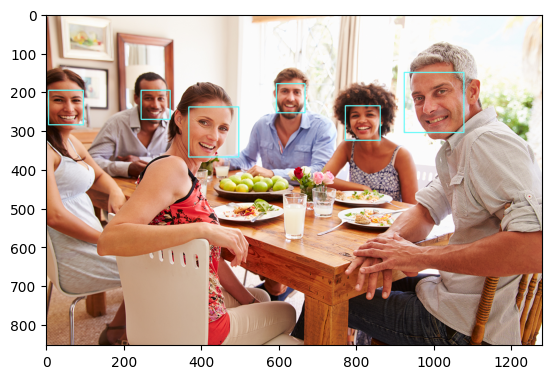

In [8]:
# Загрузка изображения
image = face_recognition.load_image_file(imagemain)

# Находим все лица на фотографии с помощью готовой нейронки
face_locations = face_recognition.face_locations(image)

print(f'Найдено {len(face_locations)} лиц на данной фотографии.')

# Отображение результатов
for top, right, bottom, left in face_locations:
    cv2.rectangle(image, (left, top), (right, bottom), (100, 250, 250), 2)

plt.imshow(image)

# Выравнивание лица  (face alignment)

### Обучение модели на задачу поиска ключевых точек лица

Буду использовать один из популярных датасетов для поиска ключевых точек 300W.
Взял уменьшенный вариант на kaggle: a300wdataset. Тут всего 300Мб, а в основном берут dataset весом 2Гб.

In [9]:
# root = '/kaggle/input/a300wdataset'
# train_imgs = '/kaggle/input/a300wdataset/train_data/imgs'
# val_imgs = '/kaggle/input/a300wdataset/test_data/imgs'

# вытаскиваю из файлов txt те колонки, в которых информация о path картинки и её landmarks
train_info = pd.read_csv('/kaggle/input/a300wdataset/trainlist.txt', sep=' ', names=[str(elem) for elem in range(146)]).iloc[:, :137]
val_info = pd.read_csv('/kaggle/input/a300wdataset/vallist.txt', sep=' ', names=[str(elem) for elem in range(146)]).iloc[:, :137]

In [10]:
# собираю датасет

class FacialLandmarksDataset(Dataset):
    def __init__(self, annotations, transforms=None):
        """
        Args:
            annotations: файл с аннотациями.
            transform (optional): Преобразования, применяемые к изображению.
        """
        self.annotations = annotations
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Получаем путь к изображению
        img_name = self.annotations.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        
        # Применяем преобразования к изображению
        if self.transforms:
            image = self.transforms(image)
            
        # Получаем ключевые точки (остальные 136 колонок)
        landmarks = self.annotations.iloc[idx, 1:].values.astype('float32')
        landmarks = landmarks.reshape(-1, 2)  # Преобразуем в массив формы (68, 2)
        # Масштабируем ключевые точки к размерам изображения
        _, height, width = image.shape  # Получаем размеры изображения
        landmarks[:, 0] *= width        # Масштабируем x-координаты
        landmarks[:, 1] *= height       # Масштабируем y-координаты

        # Возвращаем изображение и ключевые точки
        return image, torch.tensor(landmarks, dtype=torch.float32)

In [39]:
# Преобразования для изображений для train_dataset
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # случайные изменения яркости, контрасности, насыщенности и оттенка
    transforms.Resize((112, 112)),                                                  # Изменяю размер изображения
    transforms.ToTensor()                                                           # Преобразую в тензор и нормализую в [0, 1]
])

# ... для val_dataset
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])


# Создание датасета
train_dataset = FacialLandmarksDataset(annotations=train_info, transforms=transform_train)
val_dataset = FacialLandmarksDataset(annotations=val_info, transforms=transform)

# Создание даталоадера
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [12]:
def mean_error_batch(true_points_batch, predicted_points_batch):
    """
    Метрика, которую можно использовать при обучении сетки для задачи поиска ключевых точек.
    Вычисляет среднюю ошибку (Mean Error) для батча данных.

    :param true_points_batch: Массив истинных координат ключевых точек (формат: [batch_size, N, 2]).
    :param predicted_points_batch: Массив предсказанных координат ключевых точек (формат: [batch_size, N, 2]).
    :return: Средняя ошибка для всего батча (в пикселях или других единицах).
    """
    # Проверка на совпадение размеров
    if true_points_batch.shape != predicted_points_batch.shape:
        raise ValueError("Форма массивов true_points_batch и predicted_points_batch должна быть одинаковой.")

    # Вычисление евклидова расстояния между каждой парой точек для всего батча
    errors = np.linalg.norm(true_points_batch - predicted_points_batch, axis=2)  # [batch_size, N]

    # Возвращаем среднее значение ошибки для всего батча
    return np.mean(errors)

In [13]:
class WingLoss(nn.Module):
    def __init__(self, w=10, epsilon=2):
        """
        Специальная функция потерь, используемая для задач поиска ключевых точек.
        :param w: Ширина нелинейной области (по умолчанию 10).
        :param epsilon: Малое положительное число (по умолчанию 2).
        """
        super(WingLoss, self).__init__()
        self.w = w
        self.epsilon = epsilon
        
        epsilon_tensor = torch.tensor(epsilon)
        self.C = w - w * torch.log(1 + w / epsilon_tensor)  # Константа для непрерывности

    def forward(self, predictions, targets):
        """
        :param predictions: Предсказанные координаты ключевых точек (формат: [batch_size, num_points, 2]).
        :param targets: Истинные координаты ключевых точек (формат: [batch_size, num_points, 2]).
        :return: Значение Wing Loss.
        """
        # Вычисляем разницу между предсказаниями и целями
        x = predictions - targets
        abs_x = torch.abs(x)

        # Применяем Wing Loss
        loss = torch.where(
            abs_x < self.w,
            self.w * torch.log(1 + abs_x / self.epsilon),
            abs_x - self.C
        )

        # Возвращаем среднее значение по батчу
        return loss.mean()

In [14]:
def plotting_train_landmarks(loss, val_loss, avg_train_error, avg_val_error):
    """
    После каждой эпохи обучения интерактивно выводятся два графика. Первый с loss, второй с error.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 3.5))
    axes[0].plot(loss, label="train_loss")
    axes[0].plot(val_loss, label="val_loss")
    axes[0].axvline(x = val_loss.index(min(val_loss)), color = 'g', linestyle = ':')
    axes[1].plot(avg_train_error, label="train_error")
    axes[1].plot(avg_val_error, label="val_error")
    axes[1].axvline(x = avg_val_error.index(min(avg_val_error)), color = 'g', linestyle = ':')
    x = avg_val_error.index(min(avg_val_error))
    y = min(avg_val_error)
    axes[1].annotate(text=str(round(min(avg_val_error), 2)), xy=(x, y), 
                     xycoords='data',
                     xytext=(x-0.05, y+0.4),
                     textcoords='data',
                     size=9,
                     va='bottom', ha='right') 
    for i in [0,1]: 
        axes[i].set_xticks(ticks=range(0, len(loss), 1), labels=(x for x in range(1, len(loss)+1)))
        axes[i].legend()
    plt.show()

In [37]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

@torch.no_grad()
def show_landmarks(landmarks_model, dataloader):
    """
    Функция, которая выводит изображение и точки.
    зелёным цветом - target landmarks,
    красным цветом - preds landmarks.
    """
    landmarks_model.eval()
    batch_imgs, target_landmarks = next(iter(dataloader))
    images = batch_imgs.to(device)
    landmarks_pred = landmarks_model(images)
    image = images[0].cpu()
    landmarks_pred, target_landmarks = landmarks_pred[0].cpu(), target_landmarks[0].cpu()
    
    plt.figure(figsize=(7, 7))
    plt.imshow(image.permute(1,2,0))
    plt.scatter(landmarks_pred[:, 0], landmarks_pred[:, 1], s=14, marker='.', c='red')
    plt.scatter(target_landmarks[:, 0], target_landmarks[:, 1], s=14, marker='.', c='green')

In [16]:
# EarlyStopping для остановки обучения, если вышли на плато.

class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            return True
        
        return False

In [26]:
def train_landmarks_search(model, optimizer, criterion, scheduler=False, epochs=10, name_model='nn', plotting=False):

    best_val_loss = float('inf')
    best_val_error = float('inf')

    early_stopping = EarlyStopping(patience=10)

    history = []
    for epoch in range(epochs):
        
        model.train()
        avg_train_loss = 0
        avg_train_error = 0
        for inputs, landmarks_true in tqdm(train_dataloader):
            inputs, landmarks_true = inputs.to(device), landmarks_true.to(device)

            optimizer.zero_grad()
            predicted_points_batch = model(inputs)
            # Вычисление loss и средней ошибки для батча
            loss = criterion(predicted_points_batch, landmarks_true)
            error = mean_error_batch(landmarks_true.cpu(), predicted_points_batch.cpu().detach().numpy())
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_dataloader)
            avg_train_error += error / len(train_dataloader)

        if scheduler:
            scheduler.step()

        model.eval()
        avg_val_loss = 0
        avg_val_error = 0
        with torch.no_grad():
            for inputs, landmarks_true in tqdm(val_dataloader):
                inputs, landmarks_true = inputs.to(device), landmarks_true.to(device)
                landmarks_preds = model(inputs)
                loss = criterion(landmarks_preds, landmarks_true)
                error = mean_error_batch(landmarks_true.cpu(), landmarks_preds.cpu())
    
                avg_val_loss += loss.item() / len(val_dataloader)
                avg_val_error += error / len(val_dataloader)

        # Сохраняю значения для построения графиков
        history.append((avg_train_loss, avg_val_loss, avg_train_error, avg_val_error))

        # Ранняя остановка...
        if early_stopping(avg_val_loss):
            print('Early stopping!')
            break

        # вывожу на экран текущие значения метрик
        clear_output(wait=True)
        print(f'Epoch  {epoch+1}   train_loss:  {avg_train_loss:.3f},  val_loss  {avg_val_loss:.3f},  val_error  {avg_val_error:.2f}')

        # checkpoint...
        ckpt_path = '/kaggle/working/'
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if avg_val_error < best_val_error:
                best_val_error = avg_val_error
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}.pt')

        # после каждой эпохи можно видеть на графике, как меняются метрики
        if plotting:
            loss, val_loss, train_error, val_error = zip(*history)
            plotting_train_landmarks(loss, val_loss, train_error, val_error)

    # После обучения вывожу лучшие значения
    print(f'best_val_loss = {best_val_loss},   best_val_error = {best_val_error}')

    statistic = [name_model, best_val_loss, best_val_error]

    gc.collect()
    torch.cuda.empty_cache()

    return model, statistic

In [27]:
# Создаю модель для текущей задачи. Основная часть (embedder) подгружена из ResNet50 (без слоя классификации)

class myLandmarksModel(nn.Module):
    def __init__(self, model, in_features, num_points):
        super(myLandmarksModel, self).__init__()
        self.in_features = in_features
        self.num_points = num_points

        self.embedder = nn.Sequential(*(list(model.children())[:-1]))
        self.points = nn.Linear(in_features=self.in_features, out_features=self.num_points * 2, bias=True)

    def forward(self, x):
        x = self.embedder(x)
        x = x.reshape(-1, x.shape[1])
        x = self.points(x)
        x = x.reshape(-1, self.num_points, 2)
        
        return x

Epoch  25   train_loss:  8.398,  val_loss  12.757,  val_error  3.97


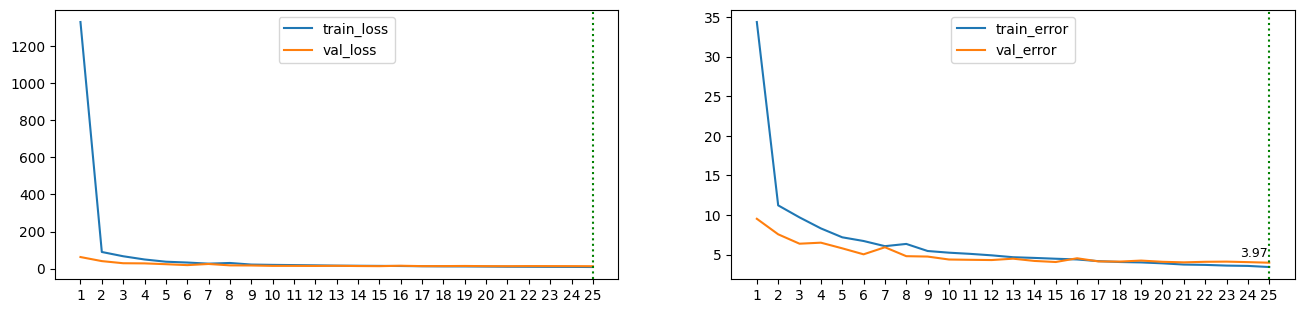

best_val_loss = 12.756556047712055,   best_val_error = 3.9713699545179098


In [30]:
# Обучаю модель с MSE Loss

model = models.resnet50(weights='IMAGENET1K_V1')

num_points = 68

landmarks_model = myLandmarksModel(model, in_features=model.fc.in_features, num_points=num_points)
landmarks_model = landmarks_model.to(device)

optimizer = torch.optim.AdamW(landmarks_model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.0005)
schedul = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

criterion1 = F.mse_loss

# Обучаю модель
landmarks_model, statistic = train_landmarks_search(landmarks_model, optimizer, criterion1, scheduler=schedul, epochs=25,
                                                    name_model='resnet50_bs32_sch_landmarks_model', plotting=True)

# Минимальный error получился 1.92

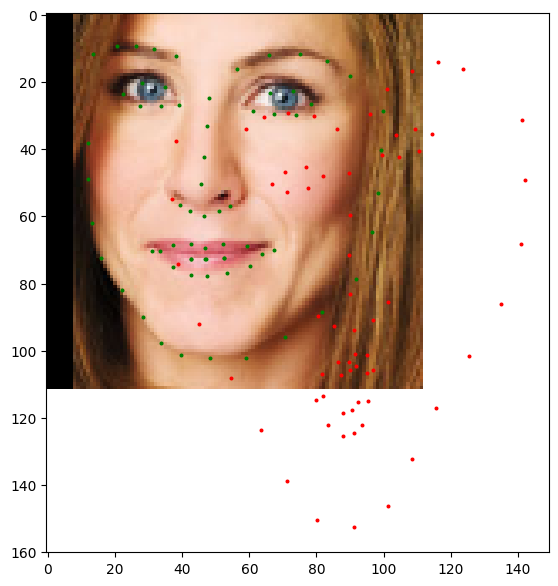

In [41]:
# Посмотрим, что получилось после обучения
show_landmarks(landmarks_model, val_dataloader)

# Напоминание: красные - preds points, зеленые - target points

Epoch  20   train_loss:  3.655,  val_loss  3.642,  val_error  3.97


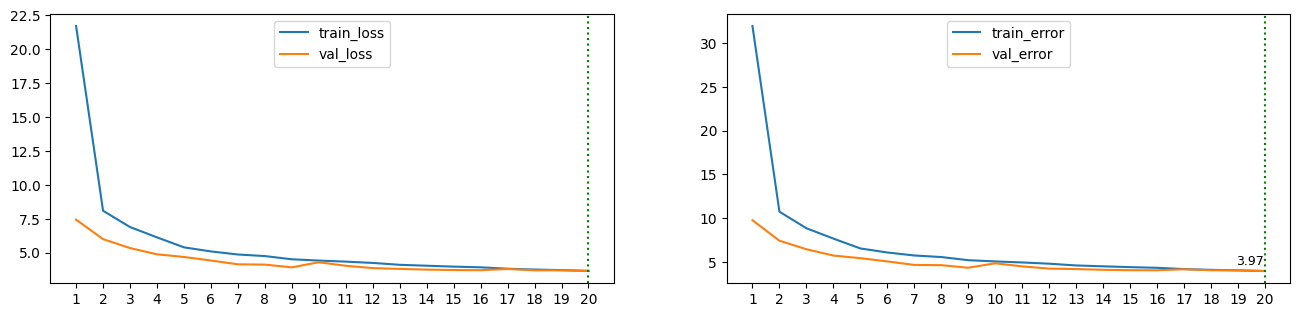

best_val_loss = 3.641847712653024,   best_val_error = 3.9662347044263564


In [28]:
# Обучаю модель с WingLoss

model = models.resnet50(weights='IMAGENET1K_V1')

num_points = 68

landmarks_model = myLandmarksModel(model, in_features=model.fc.in_features, num_points=num_points)
landmarks_model = landmarks_model.to(device)

optimizer = torch.optim.AdamW(landmarks_model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.0005)
schedul = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

criterion2 = WingLoss(w=5, epsilon=2)

# Обучаю модель
landmarks_model, statistic = train_landmarks_search(landmarks_model, optimizer, criterion2, scheduler=schedul, epochs=20,
                                          name_model='resnet50_bs32_sch_landmarks_model', plotting=True)

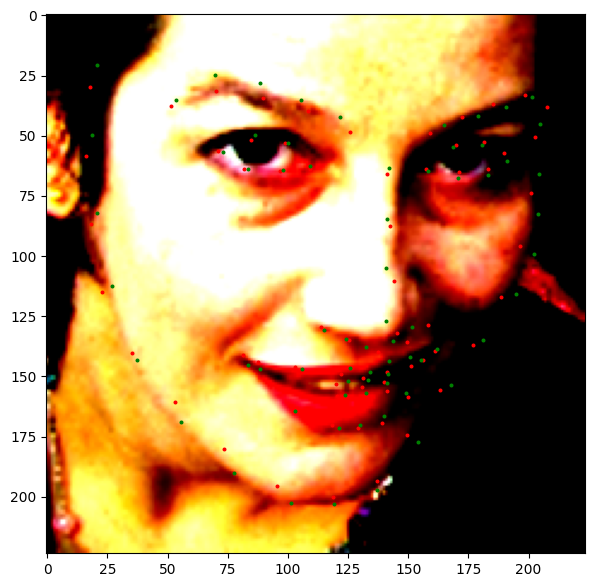

In [29]:
# Посмотрим, что получилось после обучения
show_landmarks(landmarks_model, val_dataloader)

Итак, теперь у меня есть модель, которая ищет ключевые точки лица. Может она и худенькая, но работает. 
Эта модель пригодится, когда нужно будет поворачивать изображение лица таким образом, чтобы глаза находились на уровне горизонта

In [66]:
def finding_angle(left_eye_points, right_eye_points):
    """
    handmade функция для поиска угла поворота лица.
    left_eye_points: координаты точек левого глаза, 
    right_eye_points координаты точек правого глаза:
    """
    n = len(left_eye_points)
    r = len(right_eye_points)
    # координаты точек цетров глаз
    l_w = sum([elem[0] for elem in left_eye_points]) / n
    l_h = sum([elem[1] for elem in left_eye_points]) / n
    r_w = sum([elem[0] for elem in right_eye_points]) / r
    r_h = sum([elem[1] for elem in right_eye_points]) / r

    # находим длину прилежащего и противолежащего катета
    prilezsh = abs(l_w - r_w)
    protivopolozsh = abs(l_h - r_h)

    # вычисляем значение угла в градусах
    angle = degrees(tanh(protivopolozsh / prilezsh))

    return angle if l_h <= r_h else -angle

In [67]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((NEW_SIZE, NEW_SIZE))
])

@torch.no_grad()
def new_image_transforms(model, new_image):
    """
    
    """
    # Находим на фотографии все лица
    image = face_recognition.load_image_file(new_image)
    face_locations = face_recognition.face_locations(image)
    
    faces_after_transforms = []
    model.eval()
    for face_loc in face_locations:
        # используя координаты, вырезаем с фотографии все лица
        top, right, bottom, left = face_loc
        image = Image.open(new_image).convert('RGB')
        image = np.array(image)
        image = image[top:bottom, left:right]
        face_image = transform(image)
        face_image = face_image.unsqueeze(0)
        face_image = face_image.to(device)
        # предсказываем ключевые точки для каждого лица
        face_landmarks_list = model(face_image)
        # Извлечение точек для глаз
        left_eye_points = face_landmarks_list[0][36:42, :]
        right_eye_points = face_landmarks_list[0][42:48, :]
        
        # вычисляем угол поворота и поворачиваем картинку, чтобы глаза были на линии горизонта
        angle = finding_angle(left_eye_points, right_eye_points)
        (rows, cols) = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated_img = cv2.warpAffine(image, M, (cols, rows))
        face = cv2.resize(rotated_img, (NEW_SIZE, NEW_SIZE))
        face = transforms.ToTensor()(face)
        
        faces_after_transforms.append(face)
    
    return faces_after_transforms

In [36]:
# отпрам в функцию фотографию и получаем "отгоризонталенные" лица
transformed_new_faces = new_image_transforms(landmarks_model, imagemain)

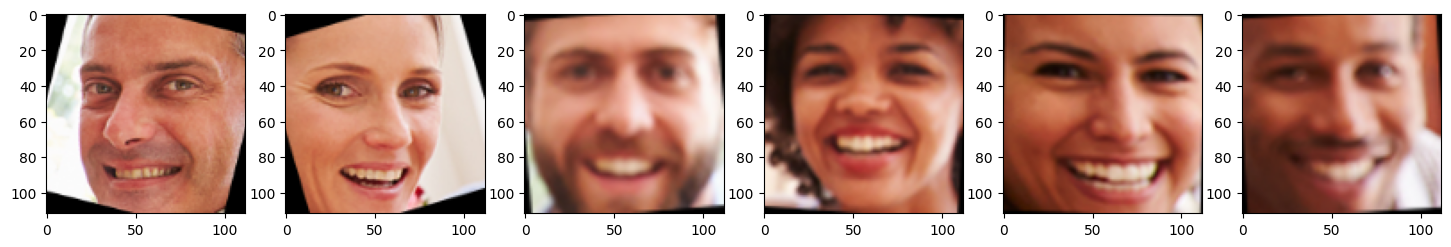

In [37]:
# смотрим на результат

plt.figure(figsize=(18, 3))
for idx in range(len(transformed_new_faces)):
    plt.subplot(1, len(transformed_new_faces), idx+1)
    plt.imshow(transformed_new_faces[idx].permute(1, 2, 0))
plt.show()

#### Для будущего самостоятельного изучения


1. изучить сетку для детекции объектов YOLOv4:
https://habr.com/ru/articles/503200/
и найти его последнюю версию
2. архитектуры для детекции лиц:
MTCNN, faceboxes
3. ещё раз посмотреть видео про сетку SSD для детекции объектов
https://stepik.org/lesson/458312/step/4?auth=login&unit=1536835
4. практика по детекции (SSD):  
https://stepik.org/lesson/458313/step/1?auth=login&unit=1536836

5. общая информация по сетям и др:
https://habr.com/ru/companies/mipt/articles/450732/

6. статьи про face detection:   
Обзор - https://arxiv.org/abs/1804.06655    
FaceNet - https://arxiv.org/abs/1503.03832  
ArcFace - https://arxiv.org/pdf/1801.07698.pdf  
CosFace - https://arxiv.org/pdf/1801.09414.pdf

# Распознавание лиц (Face Recognition)

Использую датасет CelebA500, предоставленный преподавателем

In [42]:
root_imgs = '/kaggle/input/celeba/celebA_train_500/celebA_imgs/'

print(len(os.listdir(root_imgs)))

23948


In [96]:
# с помощью pandas создаю две таблички с аннотациями к каждой фотографии 
data_classes = pd.read_csv('/kaggle/input/celeba/celebA_train_500/celebA_anno.txt', 
                           sep=' ',
                           names=['name', 'class'])

data_train_split = pd.read_csv('/kaggle/input/celeba/celebA_train_500/celebA_train_split.txt', 
                               sep=' ',
                               names=['name', 'train_val_test'])


# Сразу здесь создам списки с названиями фотографий в зависимости от train/val/test
train_imgs_names = data_train_split[data_train_split.train_val_test == 0]['name'].tolist()
val_imgs_names = data_train_split[data_train_split.train_val_test == 1]['name'].tolist()
test_imgs_names = data_train_split[data_train_split.train_val_test == 2]['name'].tolist()

In [45]:
# # проверка. 
# # нужно посмотреть на первые 4 лица из каждого файла: train, val, test. все лица должны быть одного человека
# plt.figure(figsize=(10, 8))
# for ind in range(4):
#     plt.subplot(3, 4, ind+1)
#     img = Image.open(os.path.join(root_imgs, train_imgs_names[ind]))
#     plt.imshow(img)

#     plt.subplot(3, 4, ind+5)
#     img = Image.open(os.path.join(root_imgs, val_imgs_names[ind]))
#     plt.imshow(img)
    
#     plt.subplot(3, 4, ind+9)
#     img = Image.open(os.path.join(root_imgs, test_imgs_names[ind]))
#     plt.imshow(img)
    
# plt.show()

In [173]:
# Разработаю class Dataset

class myCelebaDataset(Dataset):
    
    def __init__(self, file, labels, mode, transform=None):
        super().__init__()
        # файлы для загрузки
        self.file = file
        #
        self.mode = mode
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file)

    def load_image(self, file):
        path = os.path.join(root_imgs, file)
        image = Image.open(path) # Image.open(img_name).convert('RGB')
        # image.load()
        # image = np.array(image)
        return image

    def prepare_image(self, image):
        # cropping images
        image = np.array(image)
        img = Image.fromarray(image[77:-41, 45:-50])
        return img
    
    def __getitem__(self, index):
        name_file = self.file[index]
        x = self.load_image(name_file)
        x = self.prepare_image(x)
        if transform:
            image = self.transform(x)        
        
        label = self.labels[name_file]
        
        return image, label

In [204]:
#
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_valtest = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


labels = dict(zip(data_classes['name'], data_classes['class']))

train_dataset = myCelebaDataset(train_imgs_names, labels, mode='train', transform=transform_train)
val_dataset = myCelebaDataset(val_imgs_names, labels, mode='val', transform=transform_valtest)
test_dataset = myCelebaDataset(test_imgs_names, labels, mode='test', transform=transform_valtest)


batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

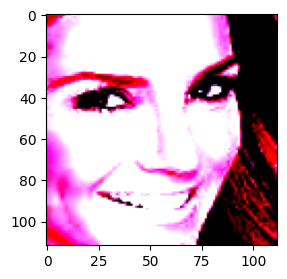

In [205]:
# проверка. 
# работает ли аугментация. нужно запустить ячейку несколько раз, картинка должна делать отзеркаливание

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)

for img, label in dataloader:
    image = img[0]
    plt.figure(figsize=(3, 3))
    plt.imshow(image.permute(1, 2, 0))
    break
plt.show()

In [112]:
# сразу после создания myCelebaDataset и dataloader's я решил проверить соответствует ли возвращаемый класс возвращаемой картинке.
# датасет сначала возвращал 3 элемента, после данной проверки я удалил из return элемент name_file, оставил только img, label

# def draft():
#     train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
#     for name_file, img, label in train_dataloader:
#         name_file = name_file[0]
#         if labels[name_file] != label.item():
#             return (f'ответ от myCelebaDataset: {name_file} имеет class {label.item()}, \n' 
#                   f'а на самом деле  {name_file} имеет class {labels[name_file]}')
#         # это проверка не повторяются ли файлы
#         if name_file in val_imgs_names:
#             return f'файл {name_file} есть в val_imgs_names'
#         if name_file in test_imgs_names:
#             return f'файл {name_file} есть в test_imgs_names'
    
#     return 'всё норм!' 

#### Обучение модели с CrossEntropy Loss

In [113]:

def plotting_train(loss, val_loss, avg_train_accur, avg_val_accur):
    """
    После каждой эпохи обучения интерактивно выводятся два графика. Первый с loss, второй с accuracy.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 3.5))
    axes[0].plot(loss, label="train_loss")
    axes[0].plot(val_loss, label="val_loss")
    axes[0].axvline(x = val_loss.index(min(val_loss)), color = 'g', linestyle = ':')
    axes[1].plot(avg_train_accur, label="train_accuracy")
    axes[1].plot(avg_val_accur, label="val_accuracy")
    axes[1].axvline(x = avg_val_accur.index(max(avg_val_accur)), color = 'g', linestyle = ':')
    x = avg_val_accur.index(max(avg_val_accur))
    y = max(avg_val_accur)
    axes[1].annotate(text=str(round(max(avg_val_accur) * 100, 2)), xy=(x, y), 
                     xycoords='data',
                     xytext=(x-0.05, y),
                     textcoords='data',
                     size=9,
                     va='bottom', ha='right') 
    for i in [0,1]: 
        axes[i].set_xticks(ticks=range(0, len(loss), 1), labels=(x for x in range(1, len(loss)+1)))
        axes[i].legend()
    plt.show()

In [157]:
def train_with_celoss(model, optimizer, criterion, scheduler=False, epochs=10, name_model='nn', plotting=False):

    best_val_loss = float('inf')
    best_val_acc = 0

    early_stopping = EarlyStopping(patience=10)

    history = []
    for epoch in range(epochs):
        
        model.train()
        avg_train_loss = 0
        avg_train_accur = 0
        for inputs, labels in tqdm(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, 1)
            accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_dataloader)
            avg_train_accur += accuracy / len(train_dataloader)

        if scheduler:
            scheduler.step()

        model.eval()
        avg_val_loss = 0
        avg_val_accur = 0
        with torch.no_grad():
            for x_batch, targets in tqdm(val_dataloader):
                x_batch, targets = x_batch.to(device), targets.to(device)
                y_pred = model(x_batch)
                loss = criterion(y_pred, targets)
                preds = torch.argmax(y_pred, 1)
                accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
                
                avg_val_loss += loss.item() / len(val_dataloader)
                avg_val_accur += accuracy / len(val_dataloader)

        history.append((avg_train_loss, avg_val_loss, avg_train_accur, avg_val_accur))

        if early_stopping(avg_val_loss):
            print('Early stopping!')
            break

        # Visualize tools
        clear_output(wait=True)
        print(f'Epoch  {epoch+1}   train_loss:  {avg_train_loss:.3f},  val_loss  {avg_val_loss:.3f},  val_accur  {avg_val_accur * 100:.2f}')

        # checkpoint
        ckpt_path = '/kaggle/working/'
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if avg_val_accur > best_val_acc:
                best_val_acc = avg_val_accur
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}.pt')

        # после каждой эпохи можно видеть на графике, как меняются метрики
        if plotting:
            loss, val_loss, train_acc, val_acc = zip(*history)
            plotting_train(loss, val_loss, train_acc, val_acc)

    print(f'best_val_loss = {best_val_loss},  best_val_acc = {best_val_acc}')

    statistic = [name_model, best_val_loss, best_val_acc]

    gc.collect()
    torch.cuda.empty_cache()

    return model, statistic

#### Обучение с CE Loss
Обучаю на классификацию. После того, как модель обучится, уберу слой классификации, чтобы получать эмбеддинги лиц

Epoch  50   train_loss:  0.001,  val_loss  1.174,  val_accur  80.47


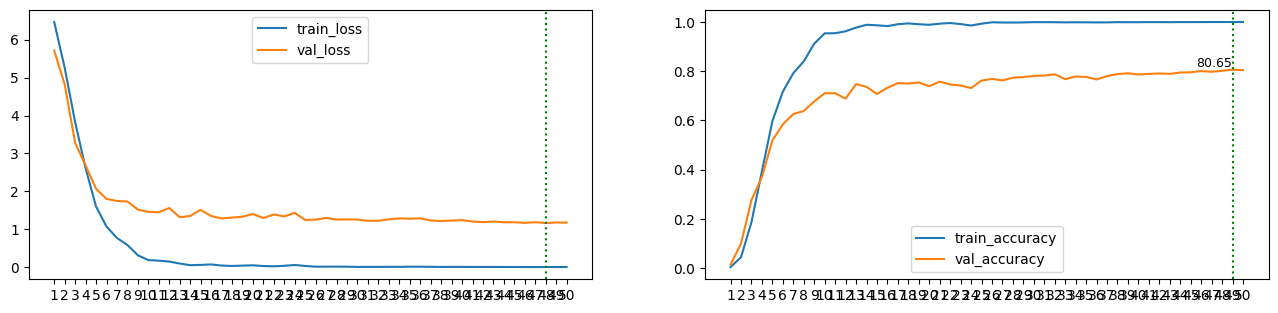

best_val_loss = 1.1612755807779607,  best_val_acc = 0.8018104776579357


In [206]:
torch.cuda.empty_cache()

# возьму обученную модель resnet34
resnet_model = models.resnet50(weights='IMAGENET1K_V1')

# output_classes = data_classes['class'].nunique()  # 500 # - это количество уникальных классов в датасете

# resnet_model.fc = nn.Linear(in_features=resnet_model.fc.in_features,
#                             out_features=output_classes)

resnet_model = resnet_model.to(device)
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

# на тестовых запусках scheduler немного помог, поэтому оставляю его
schedul = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

# обучим
celoss_model, statistic = train_with_celoss(resnet_model, optimizer, criterion, scheduler=schedul, epochs=50,
                                            name_model='resnet50_bs32_sch_celoss_model', plotting=True)

In [207]:
gc.collect()
torch.cuda.empty_cache()

In [208]:
@torch.no_grad()
def test_scores(model, data, criterion, path):
    """
    функция для вычисления accuracy на тестовых данных
    """
    model.load_state_dict(torch.load(path, weights_only=False)) # загружаю веса модели, сохранённой с минимальным loss
    model.eval()
    accuracy = 0
    for batch, targets in data:
        y_pred = model(batch.to(device))
        preds = torch.argmax(y_pred, 1)
        acc = accuracy_score(targets.numpy(), preds.cpu().numpy())
        accuracy += acc / len(data)

    print(f'{path} :\ntest_accuracy = {accuracy}')

    return [accuracy]

In [209]:
# глянем на accuracy на тестовых данных
test_accuracy = test_scores(celoss_model, test_dataloader, criterion, 'resnet50_bs32_sch_celoss_model.pt')

# добавим их в статистику по данной модели
statistic += test_accuracy

resnet50_bs32_sch_celoss_model.pt :
test_accuracy = 0.7914255617977528


In [ ]:
# создадим датафрейм, в который будем собирать метрики по каждой модели
# STATS = pd.DataFrame(index=[
#     'best_val_loss',
#     'best_val_accuracy',
#     'test_accuracy'
# ])

# # добавим в табличку первую колонку
# STATS[statistic[0]] = statistic[1:]
# STATS

In [210]:
@torch.no_grad()
def visualize_tsne(model, dataset, title):
    """
    
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    classes = range(1, 11)  # буду отбирать из датасета только первые 10 классов
    colors = ["red", "black", "brown", "green", "pink", "gray", "lightgreen", "orange", "blue", "teal"] # 10 цветов для 10 классов
    
    embeddings = []
    labels = []
    
    model.eval()
    for batch, label in tqdm(loader):
        batch, label = batch.to(device), label.to(device)
        if label in classes:
            embed = model(batch)
            embed = embed.reshape(-1, embed.shape[1])
            embeddings.append(embed)
            labels.append(label)

    embeddings = torch.cat(embeddings)
    embeddings = F.normalize(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    # Стандартизация данных (рекомендуется для TSNE)
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings_scaled)
    
    # Визуализация
    plt.figure(figsize=(8, 7))
    
    for index in classes:
        cut = labels == index
        plt.scatter(embeddings_2d[cut, 0], embeddings_2d[cut, 1],
                    color=colors[index-1],
                    label=index, marker='.', alpha=0.8)
        
    plt.xlabel('TSNE - component 1')
    plt.ylabel('TSNE - component 2')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

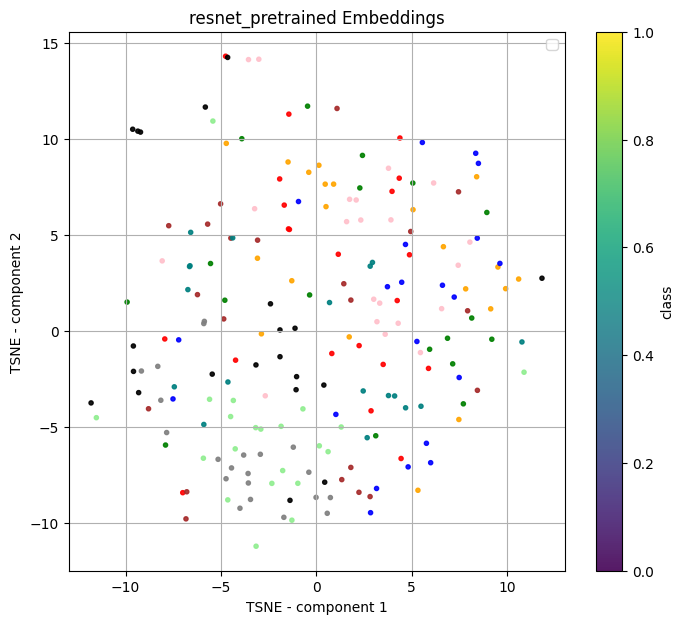

In [51]:
# просто ради интереса посмотрим как "сгруппированы" эмбеддинги лиц 10 человек на модели, которая не обучалась на задачу FaceRecognition
model_resnet_pretrained = models.resnet50(weights='IMAGENET1K_V1')
model_resnet_pretrained = torch.nn.Sequential(*(list(model_resnet_pretrained.children())[:-1])) # убираю классификатор
model_resnet_pretrained = model_resnet_pretrained.to(device)
# 
visualize_tsne(model=model_resnet_pretrained, dataset=train_dataset, title='resnet_pretrained Embeddings')

# можно видеть, что здесь абсолютный хаос

In [ ]:
# чтобы не тратить время на обучение нейронки при каждом запуске ноутбука, 
# я сохранил в /kaggle/input последний чекпоинт и теперь буду сразу использовать его
# celoss_model = models.resnet50(weights='IMAGENET1K_V1')
# path = '/kaggle/input/arcface_model/pytorch/default/1/embeds_celoss_for_FR_model.pt'
# celoss_model.load_state_dict(torch.load(path, weights_only=False))
# celoss_model = celoss_model.to(device)

In [211]:
# сохраним обученную модель, удалив последний линейный слой классификатора, чтобы на выходе получать векторы

celoss_model = torch.nn.Sequential(*(list(celoss_model.children())[:-1]))

  0%|          | 0/8544 [00:00<?, ?it/s]

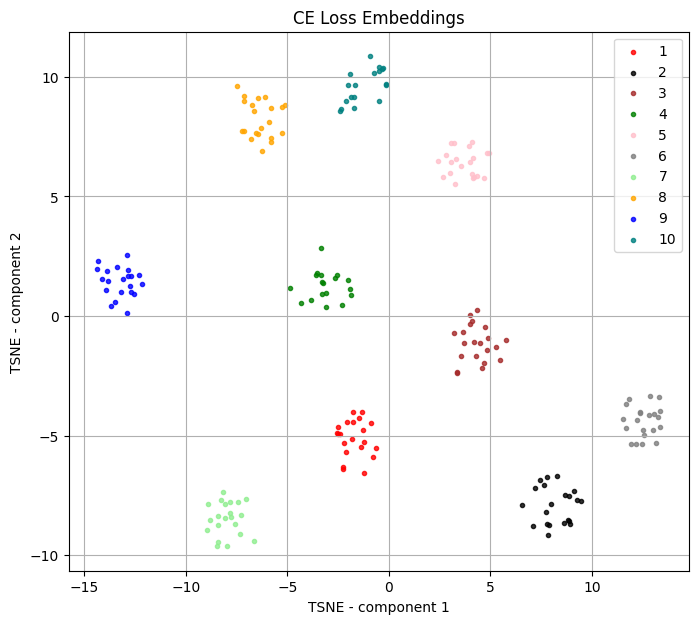

In [212]:
# берём тех же самых 10 человек, что и в прошлой визуализации и посмотрим теперь, улучшилась ли ситуация

visualize_tsne(model=celoss_model, dataset=train_dataset, title='CE Loss Embeddings')

# видим, что ситуация кардинально поменялась и векторы лиц одного и того же человека достаточно близки

In [213]:
from scipy.spatial.distance import pdist

@torch.no_grad()
def finally_model_accuracy(model):
    """
    Написал данную функцию, чтобы проверить, на сколько хорошие эмбеддинги выдаёт модель.
    input: model.
    Берётся val и test выборка. В val выборке на одного человека в среднем около 5 фотографий, в test выборке по 4 фото на человека.
    В первом цикле берём фото из val выборки, получаем его эмбеддинг, во вложенном цикле берём фото из test выборки, получаем его эмбеддинг.
    Далее замеряем косинусное расстояние между этими эмбеддингами.
    Если косинусное расстояние < 0.3 (т.е. модель показывает, что это один и тот же человек) и лэйблы этих фотографий совпадают, 
    значит программа права. Если косинусное расстояние >= 0.3 и лэйблы этих фотографий не совпадают - тоже правильно.
    В общем, если программа права, то за текущее сравнение фотографий ставлю 1, если программа не права - ставлю 0.
    
    output: accuracy  # sum(acc) / len(acc)
    """
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    model.eval()
    acc = []

    with tqdm(desc="images", total=200*160) as pbar:
        val_count = 0
        for val_img, val_label in val_dataloader:
            val_img = val_img.to(device)
            val_vector = model(val_img).reshape(-1).cpu()
            
            test_count = 0
            for test_img, test_label in test_dataloader:
                test_img = test_img.to(device)
                test_vector = model(test_img).reshape(-1).cpu()
                
                dist = pdist([val_vector, test_vector], 'cosine')
                
                if dist < 0.3 and val_label == test_label:
                    acc.append(1)
                elif dist >= 0.3 and val_label != test_label:
                    acc.append(1)
                else:
                    acc.append(0)
                
                test_count += 1
                if test_count == 160:
                    break
            
            pbar.update(160)
            val_count += 1
            if val_count == 200:
                break
    
    accuracy = sum(acc) / len(acc)

    gc.collect()
    torch.cuda.empty_cache()
    
    print(f'всего было замерено косинусных расстояний: {len(acc)},\n'
          f'точность модели составила: {accuracy * 100:.2f} %')

# переделать функцию, чтобы в ней не было dataloader

In [214]:
# запускаю, смотрю результат
finally_model_accuracy(celoss_model)

images:   0%|          | 0/32000 [00:00<?, ?it/s]

всего было замерено косинусных расстояний: 32000,
точность модели составила: 97.62 %


на 157 тысячах замеров точность получилась 97.99%

Интересно получилось, когда я стал сжимать векторы при помощи PCA (from sklearn.decomposition), то точность не только не упала, но и получилась чуть выше...

когда я замерял косинусные расстояния векторов размером 256, то accuracy = 98.07

когда я замерял косинусные расстояния векторов размером 128, то accuracy = 98.02

когда я замерял косинусные расстояния векторов размером 64, то accuracy = 97.99

когда я замерял косинусные расстояния векторов размером 32, то accuracy = 97.95

Получается, что при создании Базы Данных лиц сотрудников {вектор: face_id} можно использовать не громоздкие векторы (512), а маленькие (64 или даже 32).

#### Обучение с ArcFace Loss (Additive Angular Margin Loss)

In [215]:
class ArcFaceLoss(nn.Module):
    """
    Рализация лосс функции ArcFaceLoss
    return: logits (чтобы можно было считать метрики), loss
    """
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=64):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        # Веса последнего слоя
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size)).to(device)
        nn.init.normal_(self.weight, mean=0, std=0.01)  # Инициализация весов
        
        
    def forward(self, embeddings, labels):
        labels = labels.to(torch.long)

        # Нормализация embeddings и weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weights = F.normalize(self.weight, p=2, dim=1)

        # Вычисление косинусного сходства между эмбеддингами и весами
        cosine = F.linear(embeddings, weights)  # (batch_size, num_classes)
        cosine = torch.clamp(cosine, -1 + 1e-7, 1 - 1e-7)  # Ограничение значений для численной стабильности
        
        # Вычисление значения угла theta (углового зазора) для каждого класса
        theta = torch.acos(cosine)

        # One-hot кодирование меток
        one_hot_labels = F.one_hot(labels, self.num_classes)
        
        # Применение ArcFace границ и вычисление logits
        target_logits = torch.cos(theta + self.margin * (1 - one_hot_labels.float()))  # Применяем margin только к целевым классам
        logits = self.scale * torch.where(one_hot_labels.bool(), target_logits, cosine)  # Применяем scale
        
        # Вычисление кросс-энтропийной потери
        loss = F.cross_entropy(logits, labels)
        
        return logits, loss

In [221]:
def train_with_arcface(model, optimizer, criterion, scheduler=False, epochs=10, name_model='nn', plotting=False):

    best_val_loss = float('inf')
    best_val_acc = 0

    early_stopping = EarlyStopping(patience=10)

    history = []
    for epoch in range(epochs):
        
        model.train()
        avg_train_loss = 0
        avg_train_accur = 0
        for inputs, labels in tqdm(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(inputs)
            # embeddings = embeddings.reshape(-1, embeddings.shape[1])
            logits, loss = criterion(embeddings, labels)
            
            preds = torch.argmax(logits, 1)
            accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_dataloader)
            avg_train_accur += accuracy / len(train_dataloader)

        if scheduler:
            scheduler.step()

        model.eval()
        avg_val_loss = 0
        avg_val_accur = 0
        with torch.no_grad():
            for x_batch, targets in tqdm(val_dataloader):
                x_batch, targets = x_batch.to(device), targets.to(device)
                embeddings = model(x_batch)
                # embeddings = embeddings.reshape(-1, embeddings.shape[1])
                logits, loss = criterion(embeddings, targets)
                preds = torch.argmax(logits, 1)
                accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
                
                avg_val_loss += loss.item() / len(val_dataloader)
                avg_val_accur += accuracy / len(val_dataloader)

        history.append((avg_train_loss, avg_val_loss, avg_train_accur, avg_val_accur))

        if early_stopping(avg_val_loss):
            print('Early stopping!')
            break

        # Visualize tools
        clear_output(wait=True)
        print(f'Epoch  {epoch+1}   train_loss:  {avg_train_loss:.3f},  val_loss  {avg_val_loss:.3f},  val_accur  {avg_val_accur * 100:.2f}')

        # checkpoint
        ckpt_path = '/kaggle/working/'
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if avg_val_accur > best_val_acc:
                best_val_acc = avg_val_accur
            torch.save(model.state_dict(), f'{ckpt_path}/{name_model}.pt')

        # после каждой эпохи можно видеть на графике, как меняются метрики
        if plotting:
            loss, val_loss, train_acc, val_acc = zip(*history)
            plotting_train(loss, val_loss, train_acc, val_acc)

    print(f'best_val_loss = {best_val_loss},  best_val_acc = {best_val_acc}')

    statistic = [name_model, best_val_loss, best_val_acc]

    gc.collect()
    torch.cuda.empty_cache()

    return model, statistic

In [222]:
# судя по всему можно было просто исправить последний слой модели (model.fc = nn.Linear(in_features, embedding_size)),
# но я решил написать свой class

class myArcfaceModel(nn.Module):
    def __init__(self, model, in_features, embedding_size):
        super(myArcfaceModel, self).__init__()
        self.in_features = in_features
        self.embedding_size = embedding_size

        self.embedder = nn.Sequential(*(list(model.children())[:-1]))  # удаляю classification layer
        self.fc = nn.Linear(in_features=self.in_features, out_features=self.embedding_size, bias=True) # добавляю fc layer

    def forward(self, x):
        x = self.embedder(x)
        x = x.reshape(-1, x.shape[1])
        x = self.fc(x)
        
        return x.reshape(-1, x.shape[1])

In [223]:
in_features = 2048    # кол-во фичей, которые выдаёт embedder слой модели
embedding_size = 512  # размер вектора, который будет выдавать модель
output_classes = data_classes['class'].nunique()  # 500 # количество уникальных классов в датасете

Подбор margin и scale

In [17]:
# margins = [0.45, 0.5, 0.55]     # 0.4
# scales = [50, 55, 64, 70]       # 50

# all_scores_dict = []

# Перебор параметров
# for margin in margins:
#     for scale in scales:
#         print(f'Обучение модели с margin={margin}, scale={scale}')
#         
          # Создаем экземпляр myArcfaceModel
#         model = models.resnet50(weights='IMAGENET1K_V1')
#         model = myArcfaceModel(model, in_features, embedding_size).to(device)
#         
#         optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.0005)
#         schedul = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)
#         
          # Создаю экземпляр ArcFaceLoss
#         criterion = ArcFaceLoss(embedding_size, output_classes, margin=margin, scale=scale)
        
#         # Обучаю модель
#         arcface_model, statistic = train_with_arcface(model, train_dataloader, val_dataloader,
#                          optimizer, criterion, scheduler=schedul, epochs=30,
#                          name_model='resnet50_bs32_sch_arcface_model', plotting=True)

        # acc = statistic[3]
        # best_scores = {
        #     'acc': acc,
        #     'margin': margin,
        #     'scale': scale
        # }

        # all_scores_dict.append(best_scores)

        # for elem in all_scores_dict:
        #     print(elem)


# в итоге margin=0.4, scale=50 показали accuracy 75.7 на val выборке

Обучение модели с ArcFaceLoss и margin=0.4, scale=50 

Epoch  39   train_loss:  0.006,  val_loss  1.444,  val_accur  74.93


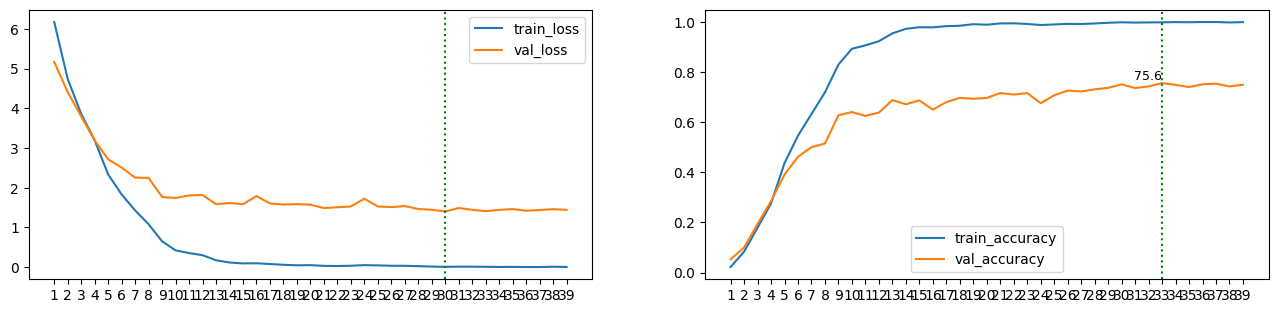

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Early stopping!
best_val_loss = 1.403289090526306,  best_val_acc = 0.7508667180277349


In [224]:
model = models.resnet50(weights='IMAGENET1K_V1')
model = myArcfaceModel(model, in_features, embedding_size).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.0005)
schedul = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

# Создаю экземпляр ArcFaceLoss
criterion = ArcFaceLoss(embedding_size, output_classes, margin=0.4, scale=55)

# Обучаю модель
arcface_model, statistic = train_with_arcface(model, optimizer, criterion, scheduler=schedul, epochs=50,
                                              name_model='resnet50_bs32_sch_arcface_model', plotting=True)

##### Конечно же параметры optimizer, scheduler и другие дались не просто так, а в ходе тестовых запусков, на которые ушло порядка 4 дней...

In [229]:
@torch.no_grad()
def test_scores_arcface(model, data, criterion, path):
    """
    
    """
    model.load_state_dict(torch.load(path, weights_only=False))
    model.eval()
    accuracy = 0
    for batch, targets in tqdm(data):
        batch, targets = batch.to(device), targets.to(device)
        embeddings = model(batch)
        logits, loss = criterion(embeddings, targets)
        preds = torch.argmax(logits, 1)
        acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
        accuracy += acc / len(data)

    print(f'{path} :\ntest_accuracy = {accuracy}')

    return [accuracy]

In [230]:
# глянем на метрики на тестовых данных
test_metrics = test_scores_arcface(arcface_model, test_dataloader, criterion, '/kaggle/working/resnet50_bs32_sch_arcface_model.pt')

# добавим их в статистику по данной модели
statistic += test_metrics

# # добавим в табличку вторую колонку
# STATS[statistic[0]] = statistic[1:]
# STATS

  0%|          | 0/16 [00:00<?, ?it/s]

/kaggle/working/resnet50_bs32_sch_arcface_model.pt :
test_accuracy = 0.7435393258426967


In [232]:
# смотрим, что с точностью на 32000 замерах косинусных расстояний
finally_model_accuracy(arcface_model)

images:   0%|          | 0/32000 [00:00<?, ?it/s]

всего было замерено косинусных расстояний: 32000,
точность модели составила: 98.31 %


  0%|          | 0/8544 [00:00<?, ?it/s]

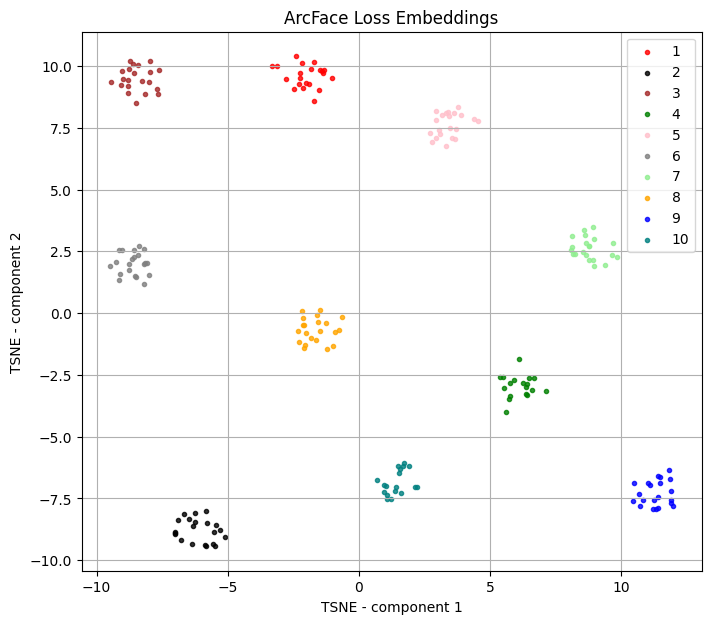

In [231]:
# берём уже третий раз всё тех же самых 10 человек, что и в прошлых визуализациях и посмотрим теперь на график
visualize_tsne(model=arcface_model, dataset=train_dataset, title='ArcFace Loss Embeddings')
# улучшение "на лицо", как говорится ))

In [ ]:
# чтобы не тратить время на обучение нейронки при каждом запуске ноутбука, 
# я сохранил в /kaggle/input последний чекпоинт и теперь буду сразу использовать его
# model = models.resnet50(weights='IMAGENET1K_V1')
# arcface_model = myArcfaceModel(model, 2048, 512)
# path = '/kaggle/input/fr_embeds_arcfaceloss_model/pytorch/default/1/embeds_arcface_for_FR_.pt'
# arcface_model.load_state_dict(torch.load(path, weights_only=False))
# arcface_model = arcface_model.to(device)

In [44]:
@torch.no_grad()
def hypersfera_plot(model, dataset):
    """
    Визуализация эмбеддингов на гиперсфере
    """ 
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    classes = range(1, 9)  # буду отбирать из датасета только первые 8 классов
    colors = ["red", "black", "brown", "green", "pink", "gray", "lightgreen", "orange"] # 8 цветов для 8 классов
    model.eval()
    embeddings = []
    labels = []
    for batch, label in tqdm(loader):
        batch, label = batch.to(device), label.to(device)
        if label.item() in classes:
            embed = model(batch)
            embed = embed.reshape(-1, embed.shape[1])
            embeddings.append(embed)
            labels.append(label)

    # Объединяем эмбеддинги и метки
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    
    # Нормализация эмбеддингов
    embeddings_normalized = F.normalize(embeddings, p=2, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    # Так как размерность эмбеддингов больше 2, используем TSNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_normalized)
    
    # Нормализация после TSNE
    embeddings_2d_normalized = embeddings_2d / np.linalg.norm(embeddings_2d, axis=1, keepdims=True)

    # Визуализация
    plt.figure(figsize=(7, 7))
    # Окружность (гиперсфера)
    theta = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), '-', label='Unit Circle', c='black', linewidth=0.2) #, markersize=12
    # Точки (эмбеддинги)
    for class_id in np.unique(labels):
        class_embeddings = embeddings_2d_normalized[labels == class_id]
        plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], 
                    color=colors[class_id-1],
                    label=class_id, alpha=0.6)
    
    # Настройки графика
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.2)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.2)
    plt.title("2D Hypersphere Visualization of Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(loc='center')
    plt.axis('equal')
    plt.show()


# Переделать, чтобы не было DataLoader

  0%|          | 0/8544 [00:00<?, ?it/s]

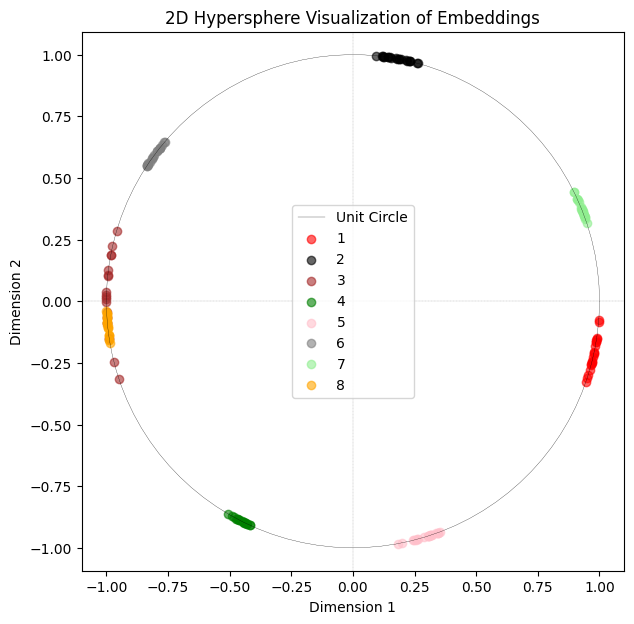

In [45]:
hypersfera_plot(arcface_model, train_dataset) # +val_dataset+test_dataset

#### Подать программе на вход фотографию, а на выходе получить эмбеддинги всех найденных лиц

In [75]:
def embeddings_from_photo(photo):
        
    # отпрам в функцию фотографию и получаем "отгоризонталенные" лица
    transformed_new_faces = new_image_transforms(landmarks_model, imagemain)
    
    faces = []
    for face in transformed_new_faces:
        one = face.unsqueeze(0)
        faces.append(one)
    
    faces = torch.cat(faces)
    faces = faces.to(device)
    
    embeddings_new_faces = arcface_model(faces)

    return embeddings_new_faces


# у нас есть картинка
imagemain = '/kaggle/working/shutterstock_292958459_GCG.jpg'

# отправляю фотографию в функцию и получаю эмбеддинги всех 6 найденных лиц
embds = embeddings_from_photo(imagemain)


embds.shape

torch.Size([6, 3, 112, 112])


torch.Size([6, 512])

# Для дальнейшего изучения:

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

### Лосс-функции для 3 части пайплайна

**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- (2 балла, обязательная часть!) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- (2 балла) Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования);
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (2 балла) Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- (2 балла) Исследовать пространство полученных эмбеддингов. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- Улучшить сеть с помощью разных трюков. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;



## Шаблон кода для Identificaton rate metric (TPR@FPR)

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [ ]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  # YOUR CODE HERE
  raise NotImplementedError

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  # YOUR CODE HERE
  raise NotImplementedError

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  # YOUR CODE HERE
  raise NotImplementedError

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  # YOUR CODE HERE
  raise NotImplementedError

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Ячейка ниже проверяет, что код работает верно:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  # YOUR CODE HERE
  pass

И ячейки для ее проверки:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [ ]:
# YOUR CODE HERE